<a href="https://colab.research.google.com/github/Ismail-therap/Covid-19-Case-Prediciton-Through-Glob/blob/master/ForecastingCOVID_19Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#######################################################################
######### Creating the star rating model using yelp data ##############
#######################################################################

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import tweepy
import os
from pathlib import Path
import json
import re
import random

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [0]:
link = 'https://drive.google.com/open?id=1DSOnFvLoZ-QT6qizRo08S8TOEZbeM1dE'
death = 'https://drive.google.com/open?id=1hv5h_iJX75IDwrDJ9dU_tIeBytt58JD4'


In [51]:
fluff, id = link.split('=')
fluff, id2 = death.split('=')
print (id2) # Verify that you have everything after '='

1hv5h_iJX75IDwrDJ9dU_tIeBytt58JD4


In [0]:
# Loading the data
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Confirmed.csv') 

dat = pd.read_csv('Confirmed.csv')
dat.head()

,Province.State,Country.Region,Lat,Long,X1.22.20,X1.23.20,X1.24.20,X1.25.20,X1.26.20,X1.27.20,X1.28.20,X1.29.20,X1.30.20,X1.31.20,X2.1.20,X2.2.20,X2.3.20,X2.4.20,X2.5.20,X2.6.20,X2.7.20,X2.8.20,X2.9.20,X2.10.20,X2.11.20,X2.12.20,X2.13.20,X2.14.20,X2.15.20,X2.16.20,X2.17.20,X2.18.20,X2.19.20,X2.20.20,X2.21.20,X2.22.20,X2.23.20,X2.24.20,X2.25.20,X2.26.20,X2.27.20,X2.28.20,X2.29.20,X3.1.20,X3.2.20,X3.3.20,X3.4.20,X3.5.20,X3.6.20,X3.7.20,X3.8.20,X3.9.20,X3.10.20,X3.11.20,X3.12.20,X3.13.20,X3.14.20,X3.15.20,X3.16.20,X3.17.20,X3.18.20,X3.19.20,X3.20.20,X3.21.20,X3.22.20,X3.23.20,X3.24.20,X3.25.20,X3.26.20,X3.27.20,X3.28.20,X3.29.20,X3.30.20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7


In [0]:
# Providing accurate column name for dates

Date = pd.date_range(start="2020-01-22",end="2020-03-30")
colname = list(Date)
dat.columns = dat.columns[:4].tolist() + colname
dat.head()


,Province.State,Country.Region,Lat,Long,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7


In [0]:
# Changing the data format to build the time series model
ldat = dat.melt(id_vars=['Province.State',"Country.Region",'Lat','Long'], 
                              var_name="Date", 
                              value_name="Confirmed")
ldat.head(n=3)

,Province.State,Country.Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0


In [0]:
# Aggregating the data table by Country and Date
agg_ldat = ldat.groupby(["Country.Region", "Date"], as_index=False)['Confirmed'].sum()
agg_ldat.head(10)

,Country.Region,Date,Confirmed
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0
5,Afghanistan,2020-01-27,0
6,Afghanistan,2020-01-28,0
7,Afghanistan,2020-01-29,0
8,Afghanistan,2020-01-30,0
9,Afghanistan,2020-01-31,0


In [0]:
# Cross checking
tab = agg_ldat.groupby(['Country.Region']).size()
tab

Country.Region
Afghanistan           69
Albania               69
Algeria               69
Andorra               69
Angola                69
                      ..
Venezuela             69
Vietnam               69
West Bank and Gaza    69
Zambia                69
Zimbabwe              69
Length: 178, dtype: int64

In [0]:
# Cross checking
datetab = agg_ldat.groupby(['Date']).size()
datetab

Date
2020-01-22    178
2020-01-23    178
2020-01-24    178
2020-01-25    178
2020-01-26    178
             ... 
2020-03-26    178
2020-03-27    178
2020-03-28    178
2020-03-29    178
2020-03-30    178
Length: 69, dtype: int64

In [0]:
# Change the column names 
agg_ldat.columns =['Country', 'Date','Confirmed']
agg_ldat.head()



,Country,Date,Confirmed
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0


In [0]:
# Exporting data which can be directly use in the ForecastArima function:
export_csv = agg_ldat.to_csv (r'RequiredDataFormat.csv', index = None, header=True) # here you have to write path, where result file will be stored


# New Section

# Building a model for China:

In [0]:
tms_dat = agg_ldat[agg_ldat.Country == "China"]

#divide into train and validation set
train = tms_dat[:int(0.8*(len(tms_dat)))]
valid = tms_dat[int(0.8*(len(tms_dat))):]


In [0]:
#building the model ARIMA model
!pip install pyramid.arima

from pyramid.arima import auto_arima
model = auto_arima(train['Confirmed'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['Confirmed'])



     |████████████████████████████████| 604kB 2.9MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=906.185, BIC=917.536, Fit time=0.360 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=915.395, BIC=919.178, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=910.090, BIC=915.766, Fit time=0.016 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=900.751, BIC=906.426, Fit time=0.088 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=902.632, BIC=910.199, Fit time=0.037 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=902.098, BIC=909.666, Fit time=0.154 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=903.965, BIC=913.424, Fit time=0.234 seconds
Total fit time: 0.920 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 2, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

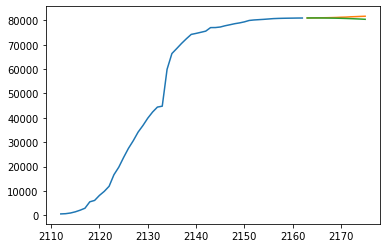

In [0]:
import matplotlib.pyplot as plt

forecast = model.predict(n_periods=len(valid["Confirmed"]))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train["Confirmed"], label='Train')
plt.plot(valid["Confirmed"], label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()


In [0]:
forecast

,Prediction
2163,80952.332833
2164,80962.578810
2165,80962.737929
2166,80952.810193
2167,80932.795599
2168,80902.694149
2169,80862.505842
2170,80812.230679
2171,80751.868659
2172,80681.419782


In [0]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid["Confirmed"],forecast))
print(rms)

604.7418559127435


In [0]:
### Create a function to predict for differernt country:

def ForecastArima(country = "China",forecast_for = 5):
    tms_dat = agg_ldat[agg_ldat.Country == country]
    #building the model
    !pip install pyramid.arima
    import numpy as np
    import csv
    import json
    from pyramid.arima import auto_arima
    model = auto_arima(tms_dat['Confirmed'], trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(tms_dat['Confirmed'])
    # Forecasting
    forecast = model.predict(n_periods=forecast_for)
    forecasted = pd.DataFrame(np.around(forecast,0),columns=['Prediction'])
    Country = pd.DataFrame([country] * 10,columns=['Country'])
    Output = pd.concat([Country,forecasted],axis=1)
    # Exporting data which can be directly use in the ForecastArima function:
    file_name = country+".csv"
    Output.to_csv (file_name, index = None) # here you have to write path, where result file will be stored

    print(Output)

In [0]:
ForecastArima(country = "US",forecast_for = 10)

  Using cached https://files.pythonhosted.org/packages/5c/84/57422f2a6ade3161c586545e38b518ba1b7ab30ee4a4acc29110c0aba2bc/pyramid_arima-0.9.0-cp36-cp36m-manylinux1_x86_64.whl
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=975.190, BIC=987.953, Fit time=0.294 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=1001.157, BIC=1005.411, Fit time=0.009 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=1001.995, BIC=1008.377, Fit time=0.025 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=1002.524, BIC=1008.906, Fit time=0.061 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=973.364, BIC=984.000, Fit time=0.211 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=996.972, BIC=1005.480, Fit time=0.185 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=976.847, BIC=989.610, Fit time=0.374 seconds
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=975.058, BIC=989.948, F

In [0]:
# How to use the function: 
# country =  The country for which we looking for forecast.
# forecast_for = number of days for which we try to predict.


Italy = ForecastArima(country = "Italy",forecast_for = 10)
US = ForecastArima(country = "US",forecast_for = 10)
GE = ForecastArima(country = "Germany",forecast_for = 10)
SP = ForecastArima(country = "Spain",forecast_for = 10)


     |████████████████████████████████| 604kB 1.3MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr

Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=1079.407, BIC=1092.635, Fit time=0.344 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=1093.980, BIC=1098.389, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=1074.890, BIC=1081.505, Fit time=0.021 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=1077.533, BIC=1084.148, Fit time=0.089 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=1076.791, BIC=1085.610, Fit time=0.028 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=1076.692, BIC=1085.511, Fit time=0.092 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=1078.655, BIC=1089.679, Fit time=0.169 seconds
Total fit time: 0.777 seconds
  Country  Prediction
0   Italy    106506.0
1   Italy    110999.0
2   Italy    115740.0
3   Italy    120454.0
4   Italy    125285.0
5   Italy    130158.0
6   Italy    135113.0
7   Italy    140127.0
8   Italy    145214.0
9

In [52]:
# Loading the data
import pandas as pd
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('deathmodel.csv') 

dat_death = pd.read_csv('deathmodel.csv', parse_dates=['date'], dayfirst=False)
# Aggregating the data table by Country and Date
agg_ldat = dat_death.groupby(["country", "date"], as_index=False)['deaths'].sum()
agg_ldat.head(10)

,country,date,deaths
0,AFG,2020-02-24,0.0
1,AFG,2020-02-25,0.0
2,AFG,2020-02-26,0.0
3,AFG,2020-02-27,0.0
4,AFG,2020-02-28,0.0
5,AFG,2020-02-29,0.0
6,AFG,2020-03-01,0.0
7,AFG,2020-03-02,0.0
8,AFG,2020-03-03,0.0
9,AFG,2020-03-04,0.0


In [0]:
### Create a function to predict for differernt country:

def ForecastDeath(country = "China",forecast_for = 5):
    tms_dat = agg_ldat[agg_ldat.country == country]
    #building the model
    !pip install pyramid.arima
    import numpy as np
    import csv
    import json
    from pyramid.arima import auto_arima
    import datetime
    from datetime import date, timedelta
    
    # Number of days predicting (Generating the date)
    numdays = forecast_for
    base = tms_dat['date'].max()
    base = base + timedelta(1)
    date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
    
    # Model fitting
    model = auto_arima(tms_dat['deaths'], trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(tms_dat['deaths'])
    
    # Forecasting
    forecast = model.predict(n_periods=forecast_for)
    forecasted = pd.DataFrame(np.around(forecast,0),columns=['Prediction'])
    Country = pd.DataFrame([country] * forecast_for,columns=['Country'])
    Date = pd.DataFrame(date_list,columns = ["Date"])
    Output = pd.concat([Date,Country,forecasted],axis=1)
    # Exporting data which can be directly use in the ForecastArima function:
    file_name = country+"death"+".csv"
    Output.to_csv (file_name, index = None) # here you have to write path, where result file will be stored


In [47]:
ForecastDeath(country = "GBR",forecast_for = 10)
ForecastDeath(country = "USA",forecast_for = 10)
ForecastDeath(country = "DEU",forecast_for = 10)
ForecastDeath(country = "ESP",forecast_for = 10)

  Using cached https://files.pythonhosted.org/packages/5c/84/57422f2a6ade3161c586545e38b518ba1b7ab30ee4a4acc29110c0aba2bc/pyramid_arima-0.9.0-cp36-cp36m-manylinux1_x86_64.whl
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=832.653, BIC=846.058, Fit time=0.313 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=857.916, BIC=862.384, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=848.925, BIC=855.628, Fit time=0.051 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=841.050, BIC=847.752, Fit time=0.058 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=844.973, BIC=856.143, Fit time=0.224 seconds
Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=831.671, BIC=847.310, Fit time=0.364 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=831.018, BIC=844.423, Fit time=0.253 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=842.622, BIC=851.559, Fit time